<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with WGANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [1]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          64129        7092        4260          18       52776       56306
Swap:          8191        1092        7099
Filesystem      Size  Used Avail Use% Mounted on
overlay         916G  874G     0 100% /
tmpfs            64M     0   64M   0% /dev
tmpfs            32G     0   32G   0% /sys/fs/cgroup
shm              64M     0   64M   0% /dev/shm
/dev/sda1       3.7T  2.1T  1.7T  55% /code/Datasets
/dev/nvme0n1p2  916G  874G     0 100% /code/content
tmpfs            32G   12K   32G   1% /proc/driver/nvidia
tmpfs           6.3G  2.8M  6.3G   1% /run/nvidia-persistenced/socket
udev             32G     0   32G   0% /dev/nvidia0
tmpfs            32G     0   32G   0% /proc/asound
tmpfs            32G     0   32G   0% /proc/acpi
tmpfs            32G     0   32G   0% /proc/scsi
tmpfs            32G     0   32G   0% /sys/firmware
Fri Dec 15 10:23:29 2023       
+----------------------------------------------

In [2]:
!pip install -qq pytorch-fid

# **Import Libraries:**

Import your required libraries!

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import argparse
import numpy as np
import os
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.utils as vutils

from torch import autograd, nn, optim
from torch.nn import functional as F

import argparse
from pprint import pprint
from torchvision import datasets, transforms
import random

import torch
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm
from torch.nn.functional import adaptive_avg_pool2d
from scipy import linalg

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu");
torch.manual_seed(1)

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [5]:
preprocess = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# Create pre-processed training and test sets
X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.data.to(device)
X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.data.to(device)

print('Train dataset shape: ', X_train.data.shape)
print('Test dataset shape: ', y_train.data.shape)

Train dataset shape:  torch.Size([60000, 784])
Test dataset shape:  torch.Size([60000, 28, 28])


In [6]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

# class ReLU(nn.ReLU):
#     def __init__(self):
#         super().__init__()

## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, num_channels=1):
        super().__init__()
        self.z_dim = z_dim

        # Define the generator layers
        self.layers = nn.Sequential(
            # Block 1: Linear -> BatchNorm
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            ReLU(),

            # Block 2: Linear -> BatchNorm
            nn.Linear(512, 7 * 7 * 64),
            nn.BatchNorm1d(7 * 7 * 64),
            ReLU(),

            # Block 3: Pixel Shuffle
            Reshape(64, 7, 7),  # Reshape to (16, 7, 7) before Pixel Shuffle
            nn.PixelShuffle(2),

            # Block 4: Conv -> BatchNorm
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            ReLU(),

            # Block 5: Pixel Shuffle
            nn.PixelShuffle(2),

            # Block 6: Conv
            nn.Conv2d(8, num_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.layers(x)

## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        # Define the discriminator layers
        self.layers = nn.Sequential(
            # Block 1: Conv -> ReLU
            nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1),
            ReLU(),

            # Block 2: Conv -> ReLU
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            ReLU(),

            # Flatten the output
            nn.Flatten(),

            # Block 3: Linear -> ReLU
            nn.Linear(7 * 7 * 64, 512),
            ReLU(),

            # Block 4: Linear
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)

## **Define Your GAN:**

In [9]:
class GAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   

    def loss_wgan(self, x_real, *, device):
        '''
        Input Arguments:
        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): WGAN discriminator (critic) loss
        - g_loss (torch.Tensor): WGAN generator loss
        '''

        # Generate fake data
        z = torch.randn((x_real.size(0), self.z_dim), device=device)
        x_fake = self.g(z)

        # Critic (discriminator) loss
        # In WGAN, the critic outputs a scalar (Wasserstein estimate)
        wasserstein_estimate_real = self.d(x_real)
        wasserstein_estimate_fake = self.d(x_fake.detach())

        # The critic aims to maximize the difference between its output on real and fake data
        d_loss = -(torch.mean(wasserstein_estimate_real) - torch.mean(wasserstein_estimate_fake))

        # Generator loss
        # The generator aims to minimize the critic's output on its generated data
        wasserstein_estimate_fake = self.d(x_fake)
        g_loss = -torch.mean(wasserstein_estimate_fake)

        return d_loss, g_loss


## **Training Process:**

In [10]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda:1",
                 iter_max=10000,
                 iter_save=1000,
                 num_latents=100,
                 out_dir=""
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents

        self.G_losses = []  # Store generator losses
        self.D_losses = []  # Store discriminator losses
        self.img_list = []  # Store generated images during training

        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            fake = ((generator(self.z_test) + 1) / 2.)
            self.img_list.append(fake)
            generator.train()

            # Show generated images
            vutils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step), nrow=10, padding=2, normalize=True)


    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))

        # Print generator and discriminator losses
        if global_step % self.iter_save == 0:
            print(f"Iteration {global_step}:")
            print(f"Generator Loss: {loss['generator_loss']:.4f}")
            print(f"Discriminator Loss: {loss['discriminator_loss']:.4f}")


    def gan_step(self, x_real, y_real):
        assert len(self.optimizers) == 2

        generator, discriminator = self.model.g, self.model.d
        g_optimizer, d_optimizer = self.optimizers

        # Compute discriminator and generator losses
        discriminator_loss, generator_loss = self.model.loss_wgan(x_real, device=self.device)

        # Update generator
        g_optimizer.zero_grad()
        generator_loss.backward(retain_graph=True)
        g_optimizer.step()

        # Update discriminator
        d_optimizer.zero_grad()
        discriminator_loss.backward()
        d_optimizer.step()
        
        # Weight clipping for the discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-0.01,0.01)

        # Update the optimizers in the class
        self.optimizers = [g_optimizer, d_optimizer]

        # Append losses to the lists
        self.D_losses.append(discriminator_loss.item())
        self.G_losses.append(generator_loss.item())

        return {"discriminator_loss": discriminator_loss, "generator_loss": generator_loss}, None

    def train(self, train_loader, reinit=False):
        global_step = 0

        # train model from scratch
        if reinit:
            # OPTIONAL: Initialize your model if needed
            pass

        # train models for multiple epochs
        with tqdm(total=int(self.iter_max)) as pbar:
            # for epoch in range(self.iter_max):
            while global_step < self.iter_max:
                for batch_idx, (x, y) in enumerate(train_loader):
                    x_real = x.to(self.device)
                    y_real = y.to(self.device)

                    loss, summaries = self.gan_step(x_real, y_real)
                    global_step += 1
                    pbar.update(1)
                    self.checkpoint_and_log(global_step, loss, summaries)

                    if global_step >= self.iter_max:
                        break

    def generate_fake_images(self, num_images):
        z = torch.randn(num_images, self.model.z_dim).to(self.device)
        with torch.no_grad():
            fake_images = self.model.g(z)
        return fake_images
    
    
    
    def evaluate_fid(self, test_loader):
        # Load the Inception model
        inception_model = inception_v3(pretrained=True, transform_input=False).to(self.device)
        inception_model.eval()

        # Generate a batch of fake images
        fake_images = self.generate_fake_images(num_images=128)  # Adjust the batch size as needed

        # Get a batch of real images
        real_images, _ = next(iter(test_loader))
        real_images = real_images.to(self.device)

        # Resize images for Inception model
        real_images = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
        fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)

        # Compute FID score
        fid_value = calculate_fretchet(real_images, fake_images, inception_model)
        print(f"FID Score: {fid_value}")
        return fid_value
    
    def plot_losses(self):
        plt.figure(figsize=(15, 5))  # Increase the figure size for three subplots
        iterations = list(range(0, len(self.D_losses) * self.iter_save, self.iter_save))

        # Subplot 1: Generator Loss
        plt.subplot(1, 3, 1)
        plt.plot(iterations, self.G_losses, label="Generator Loss", marker='o', linestyle='-')
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Generator Loss")
        plt.grid(True)
        plt.legend()

        # Subplot 2: Discriminator Loss
        plt.subplot(1, 3, 2)
        plt.plot(iterations, self.D_losses, label="Discriminator Loss", marker='o', linestyle='-')
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Discriminator Loss")
        plt.grid(True)
        plt.legend()

        # Subplot 3: Both Losses
        plt.subplot(1, 3, 3)
        plt.plot(iterations, self.G_losses, label="Generator Loss", marker='o', linestyle='-', color='blue')
        plt.plot(iterations, self.D_losses, label="Discriminator Loss", marker='o', linestyle='-', color='red')
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Generator and Discriminator Losses")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

In [11]:
mkdir result_wgan

In [13]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.RMSprop(model.g.parameters(), lr=1e-4)
    d_opt = torch.optim.RMSprop(model.d.parameters(), lr=1e-4)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 64
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='./result_wgan'
                  )

trainer.train(train_loader)

trainer.viz()

 10%|█         | 1009/10000 [00:12<02:16, 65.63it/s]

Iteration 1000:
Generator Loss: -0.0220
Discriminator Loss: -0.0650


 20%|██        | 2009/10000 [00:24<02:08, 62.38it/s]

Iteration 2000:
Generator Loss: -0.0435
Discriminator Loss: -0.0304


 30%|███       | 3009/10000 [00:36<01:53, 61.41it/s]

Iteration 3000:
Generator Loss: 0.0802
Discriminator Loss: -0.0246


 40%|████      | 4013/10000 [00:49<01:26, 68.95it/s]

Iteration 4000:
Generator Loss: 0.1516
Discriminator Loss: -0.0256


 50%|█████     | 5010/10000 [01:01<01:14, 67.18it/s]

Iteration 5000:
Generator Loss: 0.0652
Discriminator Loss: -0.0174


 60%|██████    | 6010/10000 [01:14<00:59, 66.85it/s]

Iteration 6000:
Generator Loss: 0.0951
Discriminator Loss: -0.0135


 70%|██████▉   | 6997/10000 [01:26<00:37, 79.31it/s]

Iteration 7000:
Generator Loss: -0.0239
Discriminator Loss: -0.0027


 80%|████████  | 8010/10000 [01:38<00:29, 66.69it/s]

Iteration 8000:
Generator Loss: 0.1985
Discriminator Loss: -0.0073


 90%|████████▉ | 8998/10000 [01:50<00:12, 81.90it/s]

Iteration 9000:
Generator Loss: 0.3617
Discriminator Loss: 0.0006


100%|██████████| 10000/10000 [02:03<00:00, 81.25it/s]


Iteration 10000:
Generator Loss: -0.1308
Discriminator Loss: 0.0019


## **Plot Losses:**

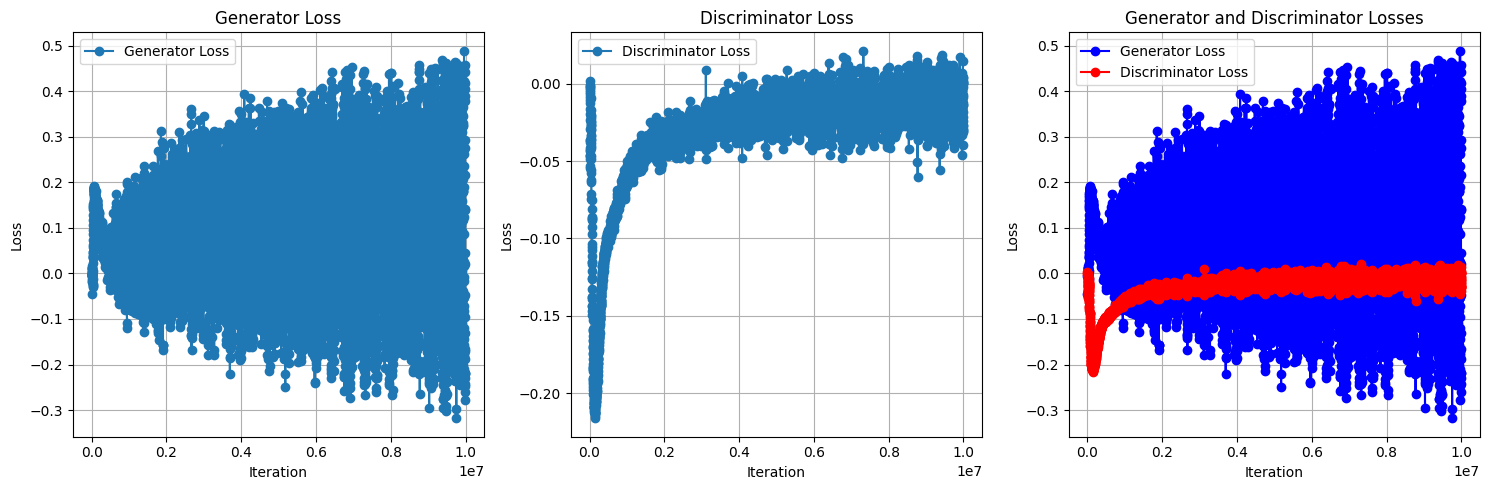

In [14]:
############################# TODO #############################
# Here, you should use the "G_losses", and "D_losses" in order to plot the "Loss Values Variation Diagram".

trainer.plot_losses()


## **Visualization:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

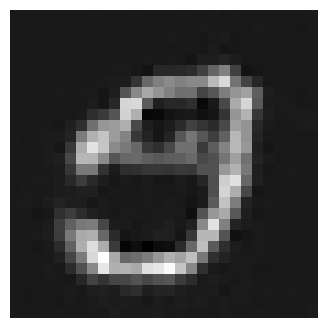

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

img_list = trainer.img_list
fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu().numpy()[0, 0], animated=True, cmap='gray')] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# **FID SCORE**

https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid

In [ ]:
# trainer.evaluate_fid(test_loader)

In [16]:
# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Set model to evaluation mode
model.eval()

# Generate fake images
num_samples = 10000  # Change this to the desired number of fake images
num_latents = 64  # Change this based on your GAN architecture

output_directory = "generated_images_wgan"
os.makedirs(output_directory, exist_ok=True)

batch_size = 2048  # Adjust the batch size based on your available memory

for batch_idx in range(num_samples // batch_size):
    # Generate random latent vectors for each batch
    z_fake = torch.randn(batch_size, num_latents, device=device)

    # Generate fake images using the generator
    with torch.no_grad():
        fake_images = model.g(z_fake).detach().cpu()

    # Save generated images for each batch
    for i in range(batch_size):
        image_path = os.path.join(output_directory, f"fake_image_{batch_idx * batch_size + i + 1}.png")
        save_image(fake_images[i], image_path)

    #print(f"Generated and saved {batch_size} fake images for batch {batch_idx + 1}.")

print(f"Generated and saved a total of {num_samples} fake images to {output_directory}.")

# # Create a directory to save the MNIST images
# mnist_directory = "mnist_images_wgan"
# os.makedirs(mnist_directory, exist_ok=True)

# # MNIST data loader
# mnist_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor()),
#     batch_size=10000,  # Use the full test set batch size
#     shuffle=True,
# )

# # Get the full batch of MNIST test images
# mnist_images, _ = next(iter(mnist_loader))
# mnist_images = mnist_images.to(device)

# # Save MNIST images
# for i in range(num_samples):
#     image_path = os.path.join(mnist_directory, f"mnist_image_{i + 1}.png")
#     save_image(mnist_images[i], image_path)

# print(f"Saved MNIST Test images to {mnist_directory}.")


Generated and saved a total of 10000 fake images to generated_images_wgan.


In [18]:
!python -m pytorch_fid  'mnist_images_gan'  'generated_images_wgan' --device cuda:1

100%|█████████████████████████████████████████| 164/164 [00:07<00:00, 20.59it/s]
FID:  49.9483332913274


In [1]:
# !rm -rf generated_images_wgan
# !rm -rf mnist_images_wgan